In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os

# Changing default dir
os.chdir("/Users/pedroteche/Documents/GitHub/icr_kaggle/")

# Pandas options
pd.set_option("display.max_columns", 500)
# Plotting options
sns.set_style("darkgrid")

In [2]:
def competition_log_loss(y_true, y_pred):
    # y_true: correct labels 0, 1
    # y_pred: predicted probabilities of class=1
    # Implements the Evaluation equation with w_0 = w_1 = 1.
    # Calculate the number of observations for each class
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    # Calculate the predicted probabilities for each class
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    # Calculate the average log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0)) / N_0
    log_loss_1 = -np.sum(y_true * np.log(p_1)) / N_1
    # return the (not further weighted) average of the averages
    return (log_loss_0 + log_loss_1) / 2

In [3]:
tb_train = pd.read_csv("data/raw/train.csv")
tb_train["EJ"] = tb_train["EJ"].astype("category")
tb_train["Class"] = tb_train["Class"].astype("category")
tb_greek = pd.read_csv("data/raw/greeks.csv")
target_var = "Class"
cat_vars = (
    tb_train.select_dtypes(include=["category"]).drop(columns=[target_var]).columns
)
num_vars = tb_train.select_dtypes(include=["number"]).columns
tb_train_full = tb_train.merge(tb_greek, on="Id", how="inner")
greek_vars = ["Alpha", "Beta", "Gamma", "Delta"]
tb_train_full_nan = tb_train_full.dropna().copy()

In [4]:
tb_train_full.to_parquet("data/processed/tb_train_full.parquet")

# EDA

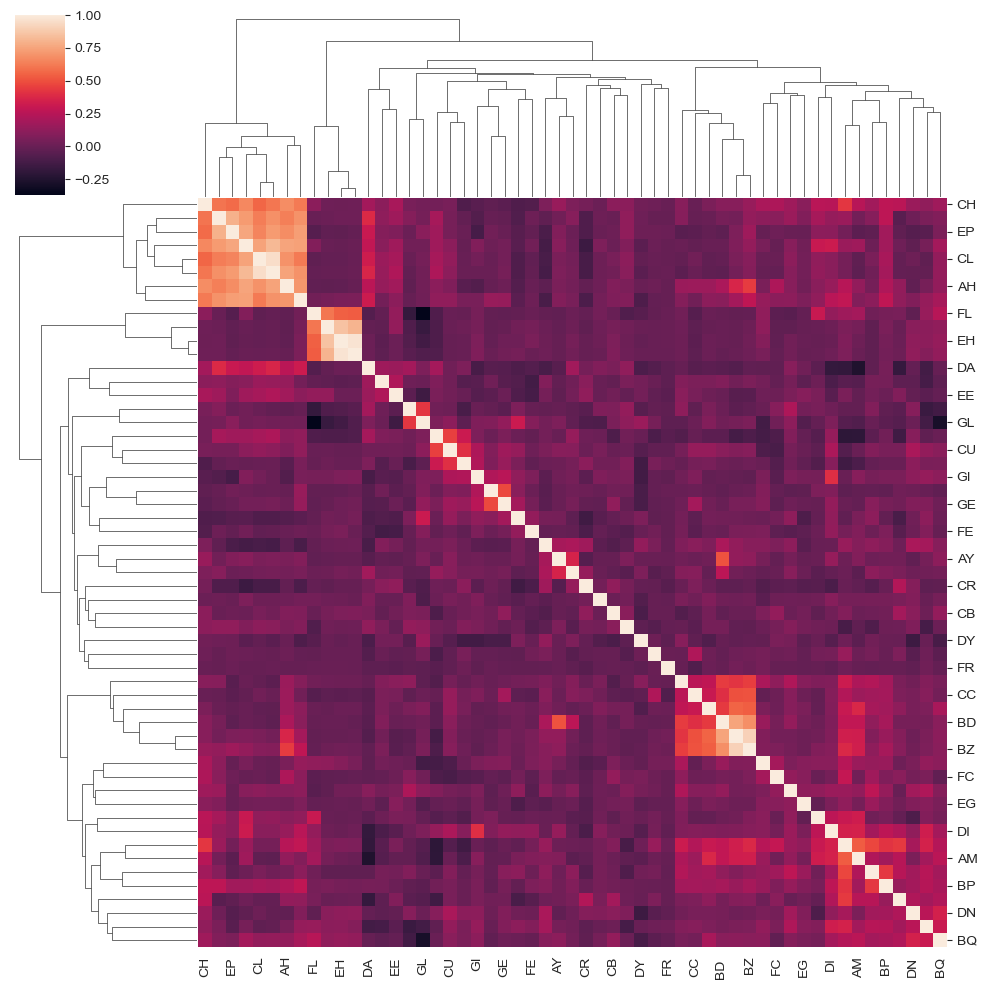

In [5]:
sns.clustermap(
    tb_train_full[num_vars].corr(),
)

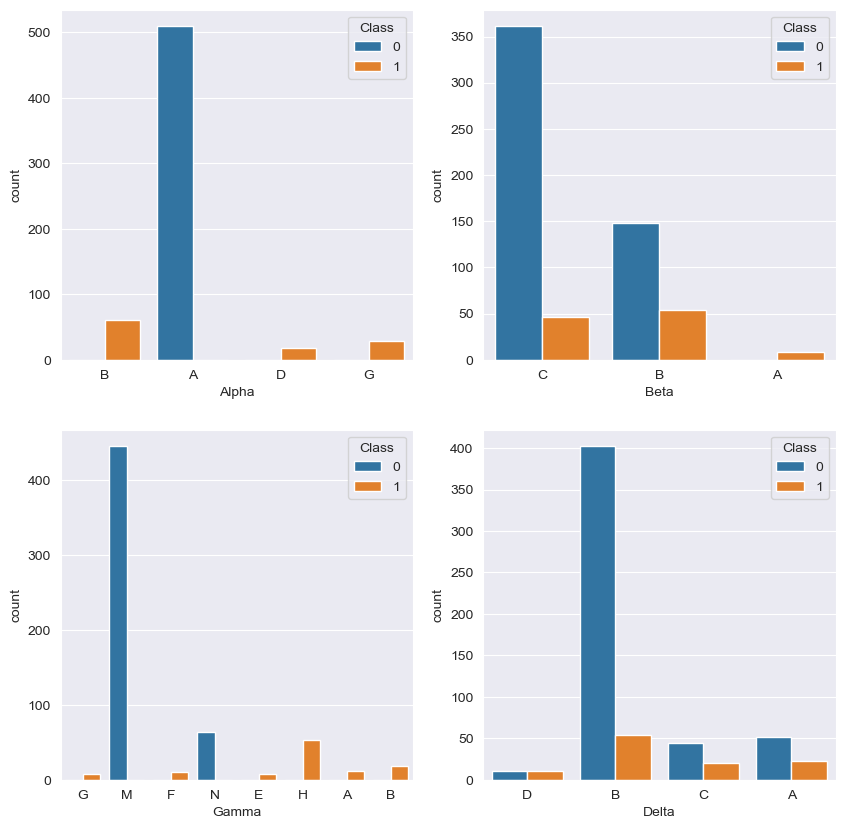

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for i, var in enumerate(greek_vars):
    sns.countplot(data=tb_train_full, x=var, hue=target_var, ax=ax[i // 2, i % 2])

In [7]:
from sklearn.decomposition import PCA

(1.0, 10.0)

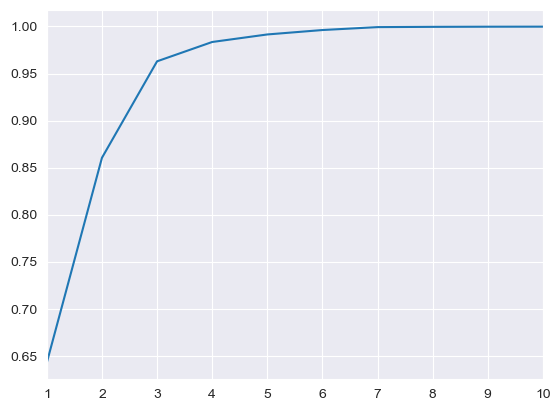

In [8]:
pca = PCA()
pca.fit(tb_train_full_nan[num_vars])

ax = sns.lineplot(
    x=np.arange(1, len(pca.explained_variance_ratio_) + 1),
    y=np.cumsum(pca.explained_variance_ratio_),
)
ax.set_xlim(1, 10)

In [9]:
pca = PCA(n_components=7)
pca.fit(tb_train_full_nan[num_vars])
tb_train_full_nan[[f"PC_{i}" for i in range(1, pca.n_components_ + 1)]] = pca.transform(
    tb_train_full_nan[num_vars]
)

<Axes: xlabel='PC_2', ylabel='PC_1'>

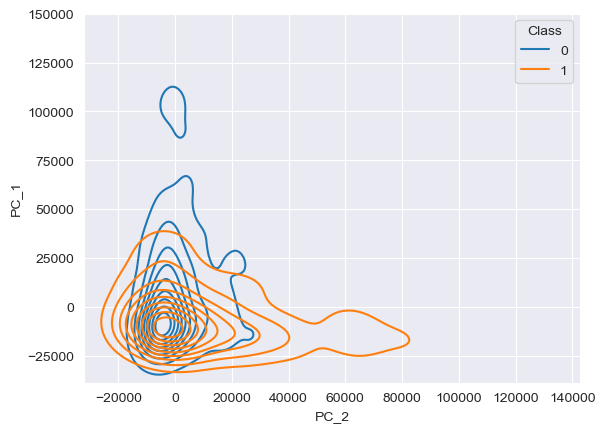

In [10]:
sns.kdeplot(data=tb_train_full_nan, x="PC_2", y="PC_1", hue="Class", common_norm=False)

<Axes: xlabel='PC_2', ylabel='PC_1'>

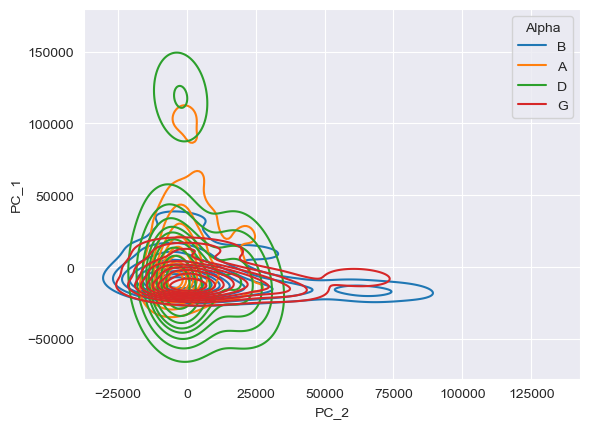

In [11]:
sns.kdeplot(data=tb_train_full_nan, x="PC_2", y="PC_1", hue="Alpha", common_norm=False)

# Baseline com regressão logística + splines

In [115]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, SplineTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from skopt import BayesSearchCV
from skopt.plots import plot_objective
from skopt.space import Integer, Categorical

In [85]:
X = tb_train_full[list(num_vars) + list(cat_vars)]
y = tb_train_full[target_var]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Numerical transforms
num_imp = KNNImputer()
sca = RobustScaler()
spl = SplineTransformer(n_knots=5, degree=3)
num_pip = Pipeline([("num_imp", num_imp), ("sca", sca), ("spl", spl)])
# Categorical transforms
ohe = OneHotEncoder()
cat_pip = Pipeline([("ohe", ohe)])
# Numerical + Categorical Transforms
preprocessor = ColumnTransformer(
    [("num", num_pip, num_vars), ("cat", cat_pip, cat_vars)]
)
# Model stack
lr = LogisticRegressionCV(max_iter=1000, cv=3, solver="liblinear")

# Full pipeline
model = Pipeline([("preprocessor", preprocessor), ("lr", lr)])

params = {
    "preprocessor__num__spl__n_knots": Integer(2, 10),
    "preprocessor__num__spl__degree": Integer(2, 10),
    "lr__penalty": Categorical(["l1", "l2"]),
    "lr__class_weight": Categorical(["balanced", None]),
}

optim_fit = BayesSearchCV(model, params, n_jobs=7, n_iter=2 * 7, n_points=7)
print(optim_fit.total_iterations)
optim_fit.fit(X_train, y_train)

56


BayesSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('num',
                                                                          Pipeline(steps=[('num_imp',
                                                                                           KNNImputer()),
                                                                                          ('sca',
                                                                                           RobustScaler()),
                                                                                          ('spl',
                                                                                           SplineTransformer())]),
                                                                          Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL'...
              n_iter=14, n_jobs=7, n_points=7,
              search_spaces={'lr__class_weight': Categorical(categories=('balanced', None), prior=None),
                             'lr__penalty': Categorical(categories=('l1', 'l2'), prior=None),
                             'preprocessor__num__spl__degree': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'preprocessor__num__spl__n_knots': Integer(low=2, high=10, prior='uniform', transform='normalize')})

In [86]:
competition_log_loss(y_test.astype(int), optim_fit.predict_proba(X_test)[:, -1])

0.5144192221964119

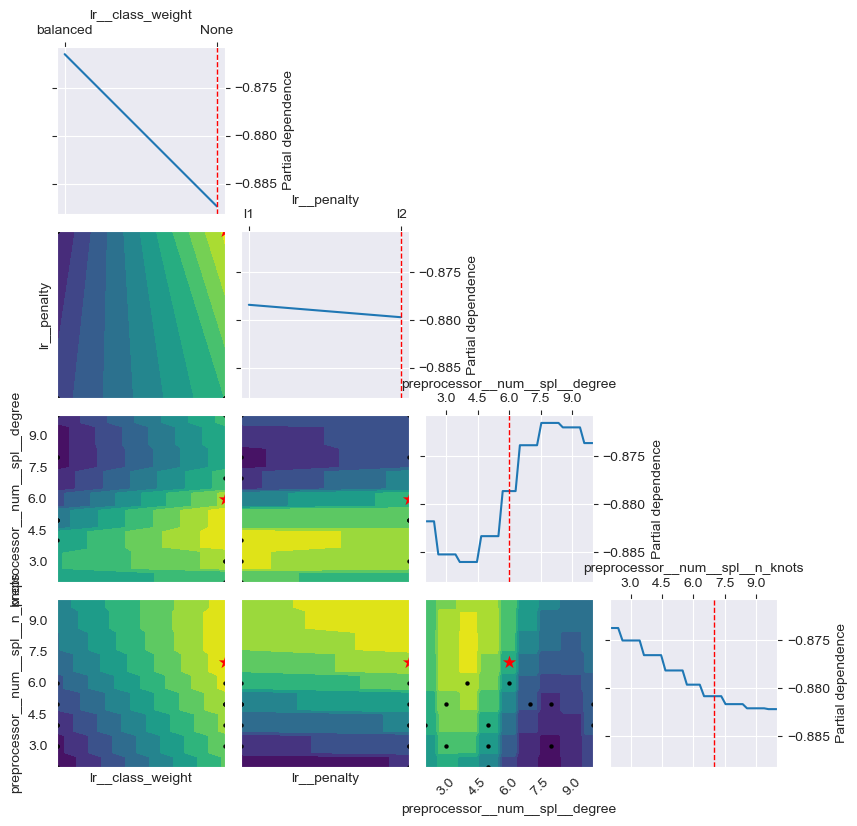

In [91]:
plot_objective(optim_fit.optimizer_results_[0])

# More exploraiton...

Idéias:

1. The *greeks* determine ta target class indirectly:
    * Alpha: B+D+G = 0 & A = 1;
    * Beta: A = 1;
    * Gamma: E+H+A+B = 1;
    * The prediction of these sub-classes might be easier than the prediction of the target class.
1. One of the big problems doing EDA on this dataset is the large amount of anonymous features.
    * Non-linear manifold learning is tricky on such a small dataset, with what appears to be much noise. Yet, it seems to be the way to go, as PCA does not provide any direct insights...

In [98]:
import umap

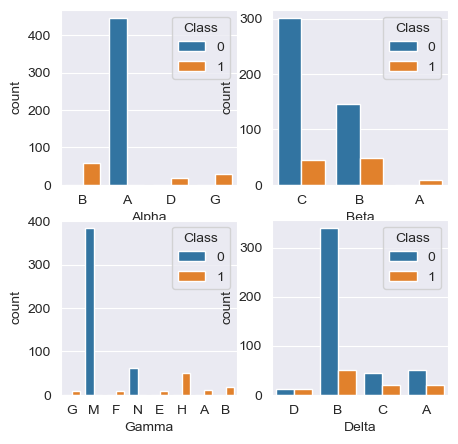

In [103]:
fig, ax = plt.subplots(2, 2, figsize=(5, 5))

for i, var in enumerate(greek_vars):
    sns.countplot(data=tb_train_full_nan, x=var, hue=target_var, ax=ax[i // 2, i % 2])

In [104]:
tb_train_full_nan["gamma_ehab"] = "O"
tb_train_full_nan.loc[tb_train_full_nan["Gamma"] == "E", "gamma_ehab"] = "EHAB"
tb_train_full_nan.loc[tb_train_full_nan["Gamma"] == "H", "gamma_ehab"] = "EHAB"
tb_train_full_nan.loc[tb_train_full_nan["Gamma"] == "A", "gamma_ehab"] = "EHAB"
tb_train_full_nan.loc[tb_train_full_nan["Gamma"] == "B", "gamma_ehab"] = "EHAB"

In [116]:
scaler = StandardScaler()
scaler.fit(tb_train_full_nan[num_vars])
reducer = umap.UMAP()
reducer.fit(scaler.transform(tb_train_full_nan[num_vars]))

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [117]:
tb_train_full_nan[[f"U_{i}" for i in range(reducer.n_components)]] = reducer.transform(
    scaler.transform(tb_train_full_nan[num_vars])
)

In [120]:
tb_train_full_nan

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha,Beta,Gamma,Delta,Epsilon,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,gamma_ehab,U_0,U_1
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.23868,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,B,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,B,C,G,D,3/19/2019,-13896.899262,-2145.329736,-496.295096,-1293.468604,-599.213304,-143.323185,372.551537,O,8.180897,6.282985
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.23868,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,A,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,A,C,M,B,Unknown,12178.697813,-3668.025128,-937.145111,-138.827695,-2283.979826,-337.357656,-194.868357,O,4.356511,3.878115
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.23868,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,B,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,A,C,M,B,Unknown,-2198.484204,-2505.562204,-701.609558,-410.368158,-877.314792,-84.168428,-93.983211,O,6.132018,7.352446
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.23868,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,B,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,A,C,M,B,Unknown,-13822.355799,-275.744212,-757.379663,-940.279629,2053.494152,13873.654287,984.098822,O,6.639217,6.779035
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.23868,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,B,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,D,B,F,B,3/25/2020,-7662.038599,5409.807182,4546.221344,92.834328,-77.600020,-202.989459,-567.136192,O,6.938689,5.870913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,fd1dd68d51b4,0.175193,2607.26686,85.200147,7.067354,8.138

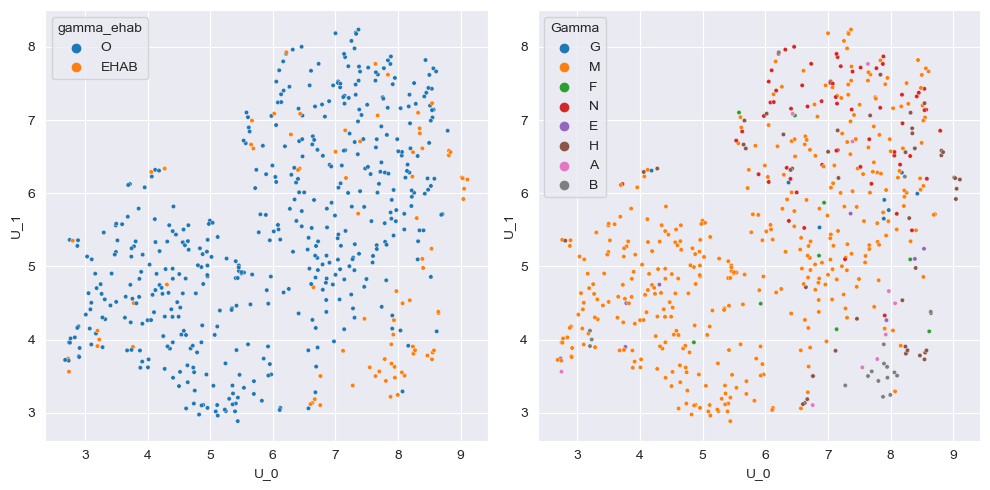

In [135]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(data=tb_train_full_nan, x="U_0", y="U_1", hue="gamma_ehab", s=10, ax=ax[0])
sns.scatterplot(data=tb_train_full_nan, x="U_0", y="U_1", hue="Gamma", s=10, ax=ax[1])
fig.tight_layout()

There appears to be some separation of Gamma = EHAB instances from the rest on the UMAP

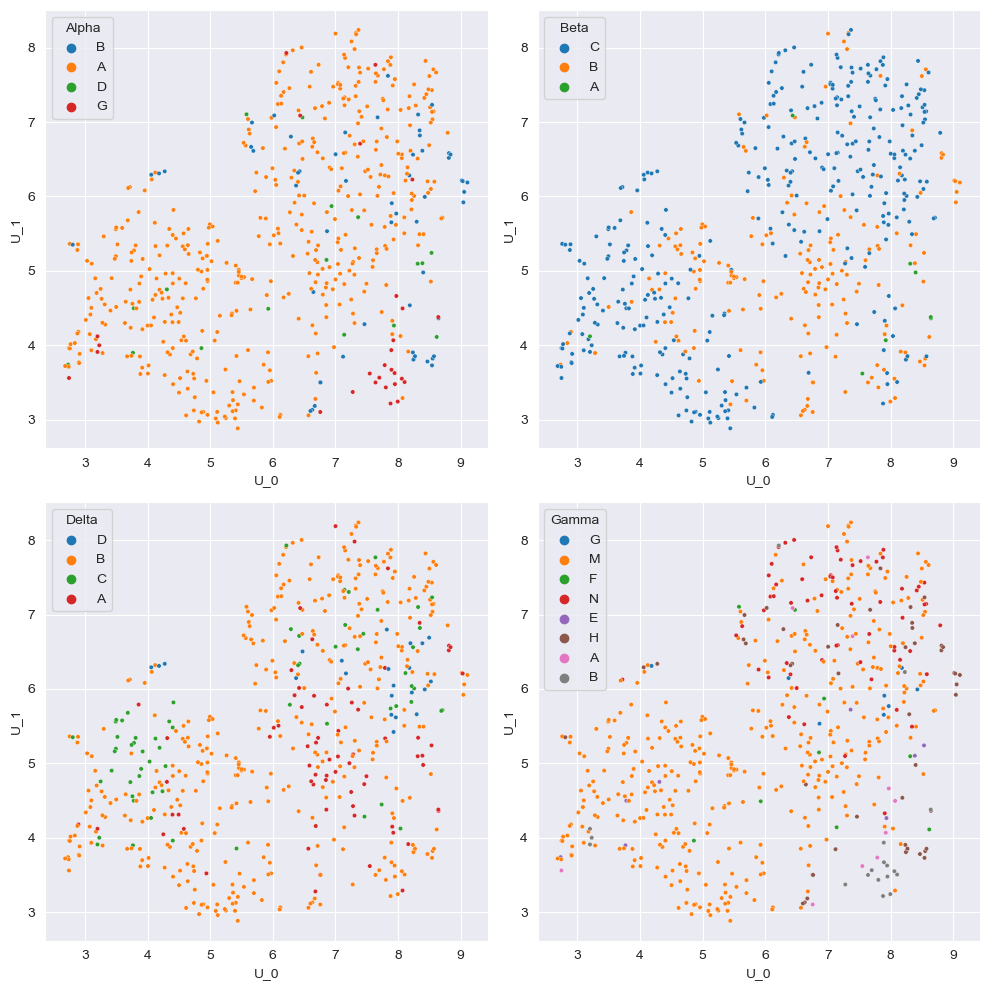

In [133]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.scatterplot(data=tb_train_full_nan, x="U_0", y="U_1", hue="Alpha", s=10, ax=ax[0,0])
sns.scatterplot(data=tb_train_full_nan, x="U_0", y="U_1", hue="Beta", s=10, ax=ax[0,1])
sns.scatterplot(data=tb_train_full_nan, x="U_0", y="U_1", hue="Delta", s=10, ax=ax[1,0])
sns.scatterplot(data=tb_train_full_nan, x="U_0", y="U_1", hue="Gamma", s=10, ax=ax[1,1])
fig.tight_layout()

One possibility is to create 4 different models which predict the probability for each *greek* and use this as input to a final model which predicts the target class.

# Greek Ensemble Model

In [ ]:
X = tb_train_full[list(num_vars) + list(cat_vars)]
y = tb_train_full["Alpha"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Numerical transforms
num_imp = KNNImputer()
sca = RobustScaler()
num_umap = umap.UMAP(n_components= 4)
num_pip = Pipeline([("num_imp", num_imp), ("sca", sca), ("umap", num_umap)])
# Categorical transforms
ohe = OneHotEncoder()
cat_pip = Pipeline([("ohe", ohe)])
# Numerical + Categorical Transforms
preprocessor = ColumnTransformer(
    [("num", num_pip, num_vars), ("cat", cat_pip, cat_vars)]
)
# Model stack
lr = LogisticRegressionCV(max_iter=1000, cv=3, solver="liblinear")

# Full pipeline
model = Pipeline([("preprocessor", preprocessor), ("lr", lr)])

params = {
    "lr__penalty": Categorical(["l1", "l2"]),
    "lr__class_weight": Categorical(["balanced", None]),
}

optim_fit = BayesSearchCV(model, params, n_jobs=7, n_iter=2 * 7, n_points=7)
print(optim_fit.total_iterations)
optim_fit.fit(X_train, y_train)